Loaded sample with track_id: ['19316957-7db5-435d-b0e5-3c99332ee329', 'ef5cd3d2-434c-4862-8d9c-afc3ea754669', '71cba3d5-f7a7-4e81-9294-e7845e3795d7', 'e7136c5f-2ab4-41fb-b76c-b4d2b5f120cc', 'f0813014-7f72-4b48-8a05-717dcb54e498', 'd889f928-241a-4d16-bc98-e8fd963473c1', '257447a6-ced9-4301-8cc6-40fd25589931', '5f21d898-b05f-43bc-a93e-d3649d8c2629', 'ec7af644-e2ea-427b-ab25-aa7e0a61ea1e', '0a143f4d-62e5-4543-8673-15e98ebcc5f7', 'f7074796-9008-46ea-b4eb-1315c0341f2d', '18db66d8-1398-4f8d-99a4-487f8676586d', '2b100ed9-80b7-4a62-99e7-f3072e08ec76', '7306580f-5138-485f-a043-f9c73e75b01a', '45ad8c1b-5f9c-44f5-84d1-0b7ddf2e1aa6', '19a91a16-2176-49a7-9127-27bc8e1c50ac', 'b4e6021a-c0bb-462e-9d5c-cd7fdd4687cb', '9e1357e9-1ad7-4e7e-b9f8-afeae59a9643', '308d18e6-55b9-4a69-888b-6ba431eca7ec', '02895667-46b9-4356-b558-281cd9484bc4', '4cd16c92-9276-49c9-9eaa-3bfe42c07435', '7f576d1f-750f-4c0d-8834-12307142bfb6', 'cd73b2f1-f09a-4d81-8513-8ecdacf39dc1', '24622491-afaf-44c4-8512-2fa673071c53', '3b4e8f7d-

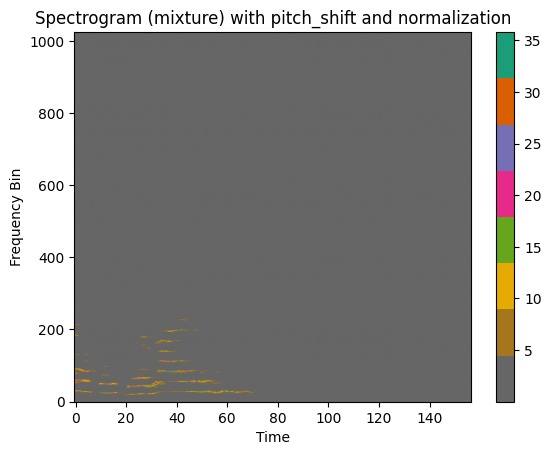

In [22]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from process_sml import AudioDatasetFolder, Compose, RandomTimeCrop, RandomTimeStretch, RandomPitchShift, RandomNoise, RandomDistortion, RandomVolume 
import torch

# Define an additional simple normalization transform:
def normalize_spec(spec: torch.Tensor) -> torch.Tensor:
    return (spec - spec.mean()) / (spec.std() + 1e-6)

COMPONENT_MAP = ["mixture", "drums", "bass", "other_accompaniment", "vocals"]

IS_TRACK_ID = True
dataset_multi = AudioDatasetFolder(
    csv_file='output_stems/musdb18_index_20250408_121813.csv',
    audio_dir='.',  # adjust as needed
    components=COMPONENT_MAP,
    sample_rate=16000,
    duration=5.0,
    is_track_id=IS_TRACK_ID,
)

loader_multi = DataLoader(dataset_multi, batch_size=32, shuffle=False)
sample_multi = next(iter(loader_multi))

if IS_TRACK_ID:
    print("Loaded sample with track_id:", sample_multi['track_id'])

# Plot spectrogram for the 'mixture' component.
spec_multi = sample_multi['vocals'][0, 0]  # select first sample and first channel
plt.imshow(spec_multi.detach().numpy(), origin='lower', aspect='auto', cmap='Dark2_r')
plt.title("Spectrogram (mixture) with pitch_shift and normalization")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.colorbar()
plt.show()


In [1]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import random
from typing import Dict

# Import missing modules for optimization
import torch.optim as optim
from torch.optim import lr_scheduler

# Import the UNet model and the training function from the training module.

from train_sml import UNet, train_model_source_separation
import torch.nn as nn
# Import our custom dataset and augmentation pipeline.
from process_sml import AudioDatasetFolder, Compose, RandomTimeCrop, RandomTimeStretch, RandomPitchShift, RandomNoise, RandomDistortion, RandomVolume 


In [2]:
augmentation_pipeline = Compose([
    RandomTimeCrop(target_time=512),
    # RandomTimeStretch(factor_range=(0.9, 1.1)),
    RandomPitchShift(shift_range=(-1.0, 1.0)),
    # RandomNoise(noise_std=0.05),
    RandomDistortion(gamma_range=(0.8, 1.2)),
    RandomVolume(volume_range=(0.8, 1.2))
])


In [3]:




# Define the component map for the dataset.
COMPONENT_MAP = ["mixture", "drums", "bass", "other_accompaniment", "vocals"]
IS_TRACK_ID = True

# Set random seeds for reproducibility.
torch.manual_seed(42)
random.seed(42)

# Choose device early.
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the dataset.
dataset_multi = AudioDatasetFolder(
    csv_file='output_stems/musdb18_index_20250408_121813.csv',
    audio_dir='.',  # adjust as needed
    components=COMPONENT_MAP,
    sample_rate=16000,
    duration=5.0,
    transform=augmentation_pipeline,  # list of transforms
    is_track_id=IS_TRACK_ID,
    input_name= "mixture"
)



In [4]:
x=dataset_multi.__getitem__(3)
x['mixture'].shape

torch.Size([2, 1025, 157])

In [5]:

# Split dataset into train and validation (e.g., 80/20 split).
dataset_size = len(dataset_multi)
indices = list(range(dataset_size))
split = int(0.8 * dataset_size)
train_indices, val_indices = indices[:split], indices[split:]
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
train_loader = DataLoader(dataset_multi, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset_multi, batch_size=32, sampler=val_sampler)
dataloaders: Dict[str, DataLoader] = {"train": train_loader, "val": val_loader}

# -------------------------------
# Model Integration
# -------------------------------
# For source separation, the model is expected to take the mixture spectrogram as input,
# and output separated source spectrograms corresponding to each target.
# --- Since the mixture is stereo, we initialize the UNet with in_channels=2 ---
model = UNet(in_channels=2)

# Define the label names (target keys) for source separation.
label_names = ["drums", "bass", "other_accompaniment", "vocals"]

# Prepare the final convolution layers for each target output.
# Here we assume that the decoder produces feature maps with 16 channels.
for key in label_names:
    model.final_convs[key] = nn.Conv2d(16, 2, kernel_size=1)

# IMPORTANT: Move the entire model to the device after adding the final conv layers.
model = model.to(device)


In [24]:
from torchsummary import summary
import torch

# Your input
input_shape = (2, 1025, 32)


# Summary with all output channels
summary(model=model, input_size=input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 1025, 32]             304
       BatchNorm2d-2         [-1, 16, 1025, 32]              32
              ReLU-3         [-1, 16, 1025, 32]               0
            Conv2d-4         [-1, 16, 1025, 32]           2,320
       BatchNorm2d-5         [-1, 16, 1025, 32]              32
              ReLU-6         [-1, 16, 1025, 32]               0
         MaxPool2d-7          [-1, 16, 512, 16]               0
            Conv2d-8          [-1, 32, 512, 16]           4,640
       BatchNorm2d-9          [-1, 32, 512, 16]              64
             ReLU-10          [-1, 32, 512, 16]               0
           Conv2d-11          [-1, 32, 512, 16]           9,248
      BatchNorm2d-12          [-1, 32, 512, 16]              64
             ReLU-13          [-1, 32, 512, 16]               0
        MaxPool2d-14           [-1, 32,

In [ ]:

# -------------------------------
# Loss Function, Optimizer, Scheduler
# -------------------------------
# Use L1 loss for source separation.
criterion = nn.L1Loss()
# Create the optimizer using the model parameters.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create a learning rate scheduler.
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# -------------------------------
# Train the Model
# -------------------------------
# Here, the input key is "mixture" and label names are defined as above.
best_model = train_model_source_separation(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=3,
    device=device,
    log_dir='./logs',
    checkpoint_dir='./checkpoints',
    input_name="mixture",  # use "mixture" for the input spectrogram from the batch
    label_names=label_names,  # list of target keys for separated sources
    print_freq=10,
)

# (Optional) Test or visualize the best_model as needed.


Epoch 1/3
----------------------------------------
Train Epoch [1/3] Batch [0/4] Loss: 1.0010 LR: 0.001000
